<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импортируем-библиотеки-и-загрузим-данные" data-toc-modified-id="Импортируем-библиотеки-и-загрузим-данные-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импортируем библиотеки и загрузим данные</a></span></li><li><span><a href="#Предобработаем-данные" data-toc-modified-id="Предобработаем-данные-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработаем данные</a></span></li><li><span><a href="#Сделаем-сводные-таблицы-и-изучим-интересующие-нас-показатели" data-toc-modified-id="Сделаем-сводные-таблицы-и-изучим-интересующие-нас-показатели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Сделаем сводные таблицы и изучим интересующие нас показатели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

### Импортируем библиотеки и загрузим данные

In [117]:
import pandas as pd
from io import BytesIO
import requests
import matplotlib.pyplot as plt

In [122]:
plt.style.use('Solarize_Light2')

In [45]:
spreadsheet_id = '1rT5e2BbW0ix-nsn0Hfvg_bNlcpnLBu5ezdKKi__z7bw'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=xlsx'.format(spreadsheet_id)
r = requests.get(file_name)
data = pd.read_excel(BytesIO(r.content))

Тебе удалось выгрузить из базы данные за январь 2024 года.
Данные содержат:
- User_id - id пользователя
- Invoice_id - номер инвойса, который оплатил пользователь
- Payment_id - id транзакции (пополнение счета через оплату инвойса)
- Session_default_channel_group - источник, по которому пользователь перешел на страницу оплаты
- Payment_date - дата транзакции
- Payment_amount - сумма транзакции
- Is_ftd - метка, обозначающая является ли данная транзакция первой для пользователя (FTD - First Time Deposit - первое пополнение)

Необходимо определить самый результативный источник привлечения клиентов. 

1. Объясни, что ты понимаешь под результативностью. 
2. Рассчитай данную метрику для всех каналов привлечения. 
3. Будет особенно круто, если отобразишь сравнение источников на графике - так руководитель отдела маркетинга сможет быстро принять решение
4. Сделай выводы, по возможности учитывая специфику бизнеса - стоит ли маркетингу изменить стратегию работы с источниками, и каким образом.


### Предобработаем данные

In [14]:
default = data.copy()

In [46]:
data = data.rename(columns={'Session default channel group':'channel'})

In [52]:
data = data.dropna(subset=['channel']).reset_index(drop=True)

In [49]:
data.is_ftd = data.is_ftd.fillna(0)

In [137]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087 entries, 0 to 1086
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   payment_id      1087 non-null   int64         
 1   user_id         1087 non-null   int64         
 2   invoice_id      1087 non-null   int64         
 3   channel         1087 non-null   object        
 4   payment_date    1087 non-null   datetime64[ns]
 5   is_ftd          1087 non-null   float64       
 6   payment_amount  1087 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 59.6+ KB


### Сделаем сводные таблицы и изучим интересующие нас показатели

In [110]:
pivot = data.pivot_table(index='channel', values='payment_amount', aggfunc='sum').reset_index()

In [111]:
pivot_count = data.groupby('channel', as_index=False)['user_id'].count()

In [112]:
pivot['cnt_users'] = pivot_count['user_id']

In [177]:
pivot['avg_check'] = round(pivot['payment_amount'] / pivot['cnt_users']).astype(int)

In [185]:
data.pivot_table(columns='channel',
            index='user_id', values='payment_amount', aggfunc='sum').mean().round().astype(int).reset_index()

,channel,0
0,Cross-network,216
1,Direct,777
2,Email,111
3,Organic Search,1252
4,Organic Social,600
5,Paid Other,50
6,Paid Search,562
7,Referral,384
8,Unassigned,101


In [187]:
pivot_ltv = data.pivot_table(columns='channel',
                    index='user_id', values='payment_amount', aggfunc='sum').mean().round().astype(int).reset_index()

In [189]:
pivot['ltv'] = pivot_ltv[0]

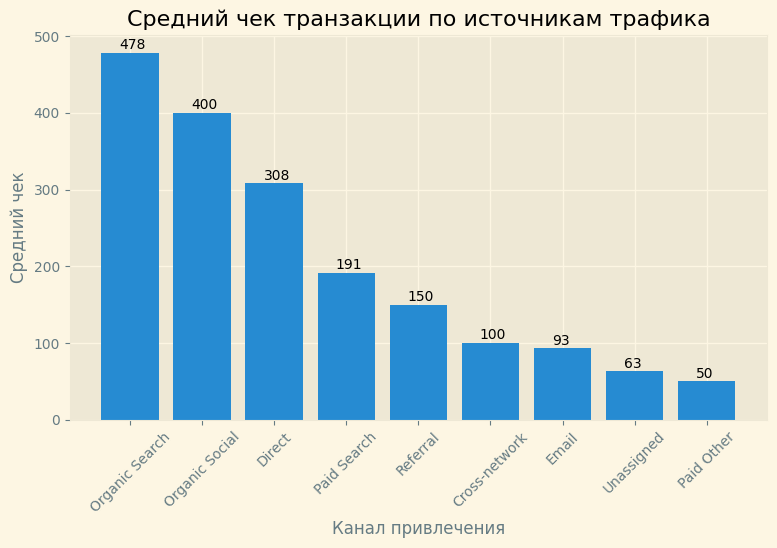

In [180]:
plt.figure(figsize=(9,5))

plt.bar(data=pivot.sort_values(by='avg_check', ascending=False), x='channel', height='avg_check')

plt.title('Средний чек транзакции по источникам трафика')
plt.xlabel('Канал привлечения')
plt.ylabel('Средний чек')
plt.xticks(rotation=45)
for i, name in enumerate(pivot.sort_values(by='avg_check', ascending=False).avg_check):
    plt.text(i-0.15, name+5, name);

In [138]:
data['channel'].unique()

array(['Paid Search', 'Referral', 'Organic Search', 'Direct',
       'Cross-network', 'Unassigned', 'Paid Other', 'Email',
       'Organic Social'], dtype=object)

Отметим 3 самых результативных канала, такие как _Organic Search, Organic Social и Direct_.

Средний чек каждой транзакции 100 и ниже - каналы _Cross-network, Email, Unassigned, Paid Other_

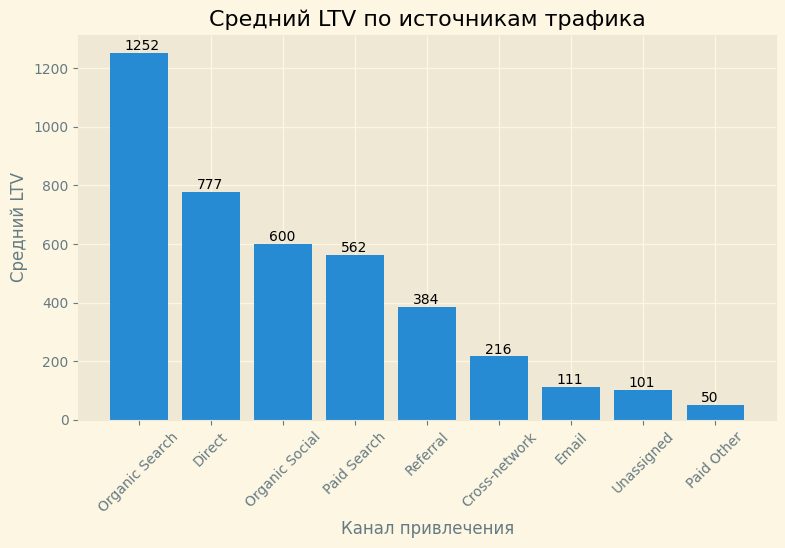

In [191]:
plt.figure(figsize=(9,5))

plt.bar(data=pivot.sort_values(by='ltv', ascending=False), x='channel', height='ltv')

plt.title('Средний LTV по источникам трафика')
plt.xlabel('Канал привлечения')
plt.ylabel('Средний LTV')
plt.xticks(rotation=45)
for i, name in enumerate(pivot.sort_values(by='ltv', ascending=False).ltv):
    plt.text(i-0.2, name+10, name);

Здесь видим ту же тройку лидеров и аутсайдеров, в целом по этим показателям источники схожи

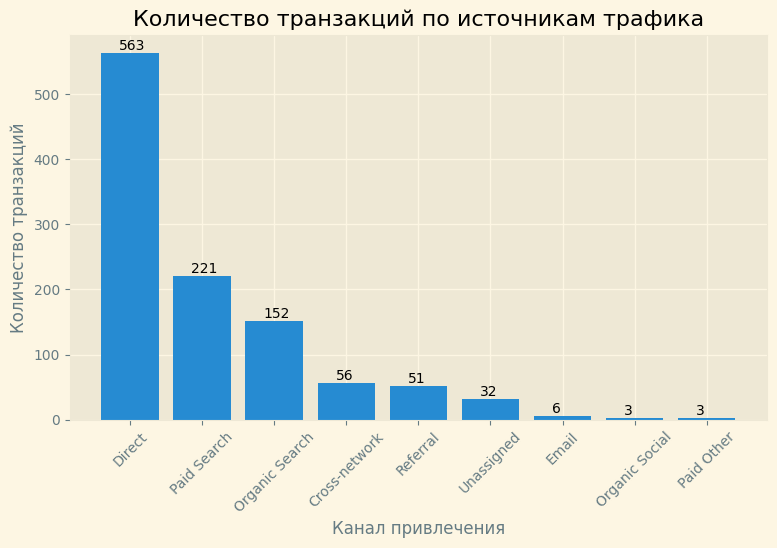

In [165]:
plt.figure(figsize=(9,5))

plt.bar(data=pivot.sort_values(by='cnt_users', ascending=False), x='channel', height='cnt_users')

plt.title('Количество транзакций по источникам трафика')
plt.xlabel('Канал привлечения')
plt.ylabel('Количество транзакций')
plt.xticks(rotation=45)

for i, name in enumerate(pivot.sort_values(by='cnt_users', ascending=False).cnt_users):
    plt.text(i-0.15, name+5, name);

Видим что через _Direct_ приходит больше всего транзакций, тогда как последние 3 канала очень малочисленны с точки зрения операций

### Выводы

Отметим самый прибыльный канал трафика - _Organic search (обычный поиск)_, у которого показатели среднего чека и ltv самые высокие в выборке. На этот канал мы не можем никак повлиять, поэтому рекомендаций по нему не будет. 

Так же отметим высокие значения среднего чека и LTV у канала _Organic Social (бесплатная реклама в социальных сетях)_, и крайне низкий показатель трафика оттуда (всего 3 транзакции). Здесь стоит пересмотреть работу с этим каналом, так как потенциально он очень прибыльный (чтобы оценить потенциал этого канала нужно чуть больше наблюдений, нежели за один месяц)

Канал _Direct (прямой трафик)_ работает неплохо, исходя из показателей, здесь я бы не стал ничего менять, хотя нет предела совершенству..

Канал _Paid Search (Поисковая реклама)_ так же стабильно приносит трафик и прибыль, здесь можно поработать со средним чеком пользователей, так как он в 2-3 раза ниже чем у Органики и Директа.

Каналы _Email, Unassigned и Paid Other_ стоит признать как неэффективные, здесь стоит в корне пересмотреть подход к работе с ними (Через почту пришло мало трафика, но доход от него есть, так что с ним стоит поработать. На Unassigned трафик повлиять мы не можем, от канала Paid Other я бы отказался вовсе, так как он затратен и неэффективен)